In [1]:
import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import src.data_proc as data_proc

In [3]:
%%time
# Load in the data
train_2016 = pd.read_csv("data/train_2016_v2.csv")
prop = pd.read_csv("data/properties_2016.csv", dtype={
    'propertycountylandusecode': str,
    'hashottuborspa': str,
    'propertyzoningdesc': str,
    'fireplaceflag': str,
    'taxdelinquencyflag': str
})

# Parse the flag attributes
def convert_true_to_float(df, col):
    df.loc[df[col] == 'true', col] = '1'
    df.loc[df[col] == 'Y', col] = '1'
    df[col] = df[col].astype(float)

for col in ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']:
    convert_true_to_float(prop, col)

CPU times: user 23.9 s, sys: 4.58 s, total: 28.4 s
Wall time: 28.6 s


In [4]:
print("Number of transaction records: {}".format(len(train_2016)))
print("Number of properties: {}".format(len(prop)))
print("Number of property features: {}".format(len(prop.columns)-1))

Number of transaction records: 90275
Number of properties: 2985217
Number of property features: 57


In [5]:
# Rename & retype the feature columns; also unify representations of missing values
data_proc.rename_columns(prop)
data_proc.retype_columns(prop)

In [55]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop, on='parcelid')

# Look at how complete (i.e. no missing value) each training set feature is
data_proc.print_complete_percentage(train_2016)
train_2016.head(30)

parcelid: 1.0
logerror: 1.0
transactiondate: 1.0
bathroom_cnt: 1.0
bedroom_cnt: 1.0
fips: 1.0
latitude: 1.0
longitude: 1.0
landuse_type_id: 1.0
census_1: 1.0
county_id: 1.0
room_cnt: 1.0
tax_year: 1.0
county_landuse_code: 0.9999889227360842
tax_parcel: 0.9999889227360842
tax_land: 0.9999889227360842
tax_property: 0.9999335364165052
region_zip: 0.9996122957629465
tax_structure: 0.9957906397119911
census_2: 0.9932982553309333
finished_area_sqft_calc: 0.9926779285516477
year_built: 0.9916255884796455
bathroom_cnt_calc: 0.9869066740515092
bathroom_full_cnt: 0.9869066740515092
city_id: 0.9800276931597895
finished_area_sqft: 0.948169482137912
lot_sqft: 0.8875657712545001
unit_cnt: 0.646391581279424
zoning_description: 0.6459484907227915
quality_id: 0.6354361672666852
heating_id: 0.6212129603987815
neighborhood_id: 0.39891442813625033
garage_cnt: 0.3316200498476876
garage_sqft: 0.3316200498476876
cooling_id: 0.318814732761008
story_cnt: 0.22785931874826917
pool_cnt: 0.19829410135696482
pool_u

,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,0100,230,HBR3YY,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,6,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,0100,230,CORH*,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,-1,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,235,NaN,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,-1,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,-1,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64


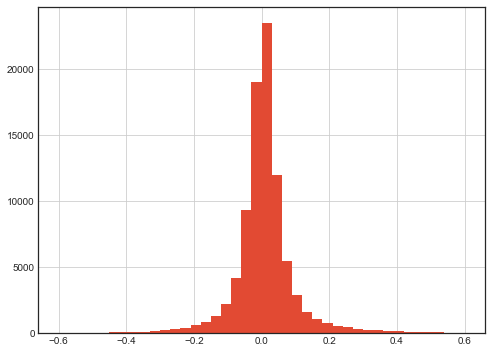

In [7]:
# Look at the distribution of the target variable (log-error)
print(train_2016['logerror'].describe())
train_2016.loc[abs(train_2016['logerror']) < 0.6, 'logerror'].hist(bins=40)

In [56]:
# Looks like there are some outliers in the training data (very large logerror)
# abs(logerror) > 0.6 seems abnormal
# Maybe should identify and remove them?
threshold = 0.6
print("{} training examples in total".format(len(train_2016)))
print("{} with abs(logerror) > {}".format((abs(train_2016['logerror']) > threshold).sum(), threshold))

train_2016 = train_2016[abs(train_2016.logerror) <= threshold]

90275 training examples in total
951 with abs(logerror) > 0.6


Analyze time data, and engineer some features!

In [10]:
datetime = pd.to_datetime(train_2016.transactiondate).dt
year = datetime.year
month = datetime.month
quarter = datetime.quarter
day = datetime.day

for m in range(1, 13):
    print("{}: {}".format(m, train_2016[month == m].logerror.median()))
print()

for q in range(1, 5):
    print("{}: {}".format(q, train_2016[quarter == q].logerror.median()))
print()

for d in range(1, 32):
    print("{}: {}".format(d, train_2016[day == d].logerror.median()))

1: 0.009000000000000001
2: 0.008
3: 0.001
4: 0.003
5: 0.003
6: 0.004
7: 0.005
8: 0.005
9: 0.01
10: 0.01
11: 0.0119
12: 0.01

1: 0.005
2: 0.003
3: 0.006999999999999999
4: 0.0109

1: 0.005
2: 0.005
3: 0.006999999999999999
4: 0.008
5: 0.008
6: 0.006999999999999999
7: 0.008
8: 0.005
9: 0.006999999999999999
10: 0.003
11: 0.005
12: 0.0055
13: 0.005
14: 0.008
15: 0.005
16: 0.006
17: 0.006
18: 0.005
19: 0.006
20: 0.006
21: 0.005
22: 0.005
23: 0.004
24: 0.004
25: 0.003
26: 0.005
27: 0.006
28: 0.005
29: 0.005
30: 0.006
31: 0.003


In [57]:
datetime = pd.to_datetime(train_2016.transactiondate).dt
train_2016['year'] = datetime.year
train_2016['month'] = datetime.month
train_2016['quarter'] = datetime.quarter

In [22]:
print(train_2016.groupby('year')['year', 'logerror'].median())
print(train_2016.groupby('month')['month', 'logerror'].median())
print(train_2016.groupby('quarter')['quarter', 'logerror'].median())

      year  logerror
year                
2016  2016     0.005
       month  logerror
month                 
1          1    0.0090
2          2    0.0080
3          3    0.0010
4          4    0.0030
5          5    0.0030
6          6    0.0040
7          7    0.0050
8          8    0.0050
9          9    0.0100
10        10    0.0100
11        11    0.0119
12        12    0.0100
         quarter  logerror
quarter                   
1              1    0.0050
2              2    0.0030
3              3    0.0070
4              4    0.0109


Analyze location and neighborhood data, and see if we can extract some features

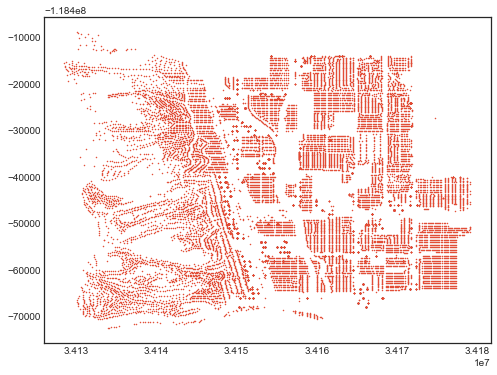

In [6]:
temp = prop[prop.regionidneighborhood == 27080]
plt.scatter(temp.latitude, temp.longitude, s=1)

In [8]:
temp.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
count,1.889100e+04,11724.000000,0.0,0.0,18891.000000,18891.000000,96.000000,18766.000000,18720.000000,0.0,0.0,18834.000000,18309.000000,0.0,525.000000,0.0,0.0,18891.0,0.0,18720.000000,0.0,0.0,342.0,18276.000000,1.889100e+04,1.889100e+04,18413.000000,8237.0,0.0,342.0,0.0,8237.0,18891.000000,1.889100e+04,18891.0,18891.0,18891.0,18891.000000,18891.0,0.0,0.0,0.0,18733.000000,0.0,0.0,18837.000000,72.000000,0.0,1.884400e+04,1.889100e+04,18891.0,1.889100e+04,18859.000000,380.0,380.000000,1.874500e+04
mean,1.086856e+07,1.029683,NaN,NaN,2.508390,2.880578,3.791667,5.190664,2.531303,NaN,NaN,1989.878889,1929.819051,NaN,4084.422857,NaN,NaN,6037.0,NaN,2.531303,NaN,NaN,1.0,3.010341,3.415643e+07,-1.184431e+08,17977.377994,1.0,NaN,1.0,NaN,1.0,260.959187,6.037135e+07,12447.0,3101.0,27080.0,96413.955429,0.0,NaN,NaN,NaN,1.056958,NaN,NaN,1961.475394,1.013889,NaN,2.281248e+05,5.610995e+05,2015.0,3.335423e+05,7275.323798,1.0,14.110526,6.037135e+13
std,2.407308e+04,0.596105,NaN,NaN,1.155497,1.134254,0.408248,1.783481,1.135503,NaN,NaN,1900.759920,1149.686222,NaN,8896.470560,NaN,NaN,0.0,NaN,1.135503,NaN,NaN,0.0,2.039407,1.152408e+04,1.545004e+04,23243.414211,0.0,NaN,0.0,NaN,0.0,16.159212,7.254457e+01,0.0,0.0,0.0,37.326321,0.0,NaN,NaN,NaN,0.991482,NaN,NaN,20.193119,0.117851,NaN,4.003192e+05,6.738291e+05,0.0,3.703873e+05,8693.946943,0.0,1.461338,1.004821e+08
min,1.084358e+07,1.000000,NaN,NaN,0.000000,0.000000,3.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,785.000000,NaN,NaN,6037.0,NaN,1.000000,NaN,NaN,1.0,2.000000,3.412853e+07,-1.184725e+08,644.000000,1.0,NaN,1.0,NaN,1.0,31.000000,6.037124e+07,12447.0,3101.0,27080.0,96058.000000,0.0,NaN,NaN,NaN,1.000000,NaN,NaN,1886.000000,1.000000,NaN,1.000000e+00,9.000000e+00,2015.0,9.000000e+00,11.180000,1.0,6.000000,6.037124e+13
25%,1.084983e+07,1.000000,NaN,NaN,2.000000,2.000000,4.000000,4.000000,2.000000,NaN,NaN,1306.000000,1297.000000,NaN,2024.000000,NaN,NaN,6037.0,NaN,2.000000,NaN,NaN,1.0,2.000000,3.414837e+07,-1.184562e+08,6751.000000,1.0,NaN,1.0,NaN,1.0,261.000000,6.037129e+07,12447.0,3101.0,27080.0,96412.000000,0.0,NaN,NaN,NaN,1.000000,NaN,NaN,1948.000000,1.000000,NaN,1.096242e+05,2.424245e+05,2015.0,9.689000e+04,3223.895000,1.0,14.000000,6.037129e+13
50%,1.086043e+07,1.000000,NaN,NaN,2.000000,3.000000,4.000000,4.000000,2.000000,NaN,NaN,1666.000000,1645.000000,NaN,2752.000000,NaN,NaN,6037.0,NaN,2.000000,NaN,NaN,1.0,2.000000,3.415620e+07,-1.184448e+08,8491.000000,1.0,NaN,1.0,NaN,1.0,261.000000,6.037141e+07,12447.0,3101.0,27080.0,96420.000000,0.0,NaN,NaN,NaN,1.000000,NaN,NaN,1955.000000,1.000000,NaN,1.589375e+05,4.250000e+05,2015.0,2.470000e+05,5465.020000,1.0,15.000000,6.037141e+13
75%,1.089466e+07,1.000000,NaN,NaN,3.000000,3.000000,4.000000,7.000000,3.000000,NaN,NaN,2240.000000,2199.000000,NaN,3868.000000,NaN,NaN,6037.0,NaN,3.000000,NaN,NaN,1.0,2.000000,3.416600e+07,-1.184299e+08,18663.000000,1.0,NaN,1.0,NaN,1.0,266.000000,6.037141e+07,12447.0,3101.0,27080.0,96424.000000,0.0,NaN,NaN,NaN,1.000000,NaN,NaN,1978.000000,1.000000,NaN,2.428602e+05,6.900390e+05,2015.0,4.578925e+05,8876.150000,1.0,15.000000,6.

In [8]:
# Let's see if there are any feature value outliers -> looks like things are fine, no need to process
prop_2017.describe().loc[['min', 'max', 'mean']].T

,min,max,mean
parcelid,1.071172e+07,1.696019e+08,1.332586e+07
basement_sqft,2.000000e+01,8.516000e+03,6.472206e+02
bathroom_cnt,0.000000e+00,3.200000e+01,2.216196e+00
bedroom_cnt,0.000000e+00,2.500000e+01,3.093362e+00
quality_id,1.000000e+00,1.200000e+01,6.280822e+00
bathroom_cnt_calc,1.000000e+00,3.200000e+01,2.303826e+00
deck_id,6.600000e+01,6.600000e+01,6.600000e+01
floor1_sqft,1.000000e+00,3.130300e+04,1.379811e+03
finished_area_sqft_calc,1.000000e+00,9.525760e+05,1.831058e+03
finished_area_sqft,1.000000e+00,4.270790e+05,1.763679e+03
